In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Índice y consideración sobre el precio

Para nuestro análisis disponemos del campo 'Adj. Close', que se trata del precio de cierre descontando los efectos de acciones corporativas como pago de dividendos, splits, etc., ideal para un análisis a largo plazo como el nuestro.
Para el etiquetado de nuestros registros, deberemos obtener un índice del sector bancario del tipo 'Total return', calculado también de forma que se excluyen los efectos de los pagos de dvidendos u otras acciones.
Probamos con el Dow Jones U.S. Financials Index, obteniendo información histórica desde 2008 en Yahoo Finance https://finance.yahoo.com/quote/%5EDJUSFN/

In [2]:
# Volcamos en un dataframe los datos obtenidos del índide
bank_index = pd.read_csv('../datos/DJUSFN.csv', sep=',', index_col='Date')
bank_index.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,463.364014,463.364014,463.364014,463.364014,463.364014,0.0
2008-01-03,459.412994,459.412994,459.412994,459.412994,459.412994,0.0
2008-01-04,446.221008,446.221008,446.221008,446.221008,446.221008,0.0
2008-01-07,448.487000,448.487000,448.487000,448.487000,448.487000,0.0
2008-01-08,432.351013,432.351013,432.351013,432.351013,432.351013,0.0


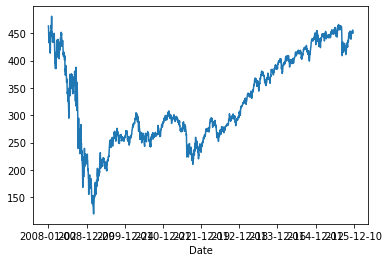

In [3]:
bank_index['Adj Close'].plot()

## Etiquetado

En este momento disponemos de tres tablas diferentes:

- mergedbalres
- banks_cotiz
- bank_index

Para poder asignar a cada trimestre analizado la etiqueta adecuada debemos seguir los siguientes pasos:

    1) Volcar el precio de Bank_index en la fecha de publicación de resultados en cada registro de mergedbalres
    2) Volcar el precio de Bank_index en la fecha de publicación de resultados + 90 días en cada registro de mergedbalres
    3) Volcar el precio de banks_cotiz para el Ticker correspondiente en la fecha de publicación de resultados en cada registro de mergedbalres
    4) Volcar el precio de banks_cotiz para el Ticker correspondiente en la fecha de publicación de resultados + 90 días en cada registro de mergedbalres
    5) Calcular en mergedbalres, para cada registro, la variación porcentual tanto del índice como del Ticker
    6) Comparar ambas variaciones y asignar la etiqueta correspondiente: entre +1% y -1% 'neutro'; más de 1% a favor de Ticker 'mejor'; menos de -1% con respecto índice 'peor'.

### 1) Precio de Bank_index a mergedbalres en d (fecha de publicación)

In [3]:
mergedbalres=pd.read_csv('../tablas/mergedbalres.csv', index_col='Ref')
banks_cotiz = pd.read_csv('../datos/banks_cotiz.csv', sep=',', date_parser='Dates')